In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import json
from tqdm import tqdm
import html
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\dhyey\anaconda3\envs\cudatest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=512):
        self.texts = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                cleaned_text = self.preprocess_text(data['text'])
                self.texts.append(cleaned_text)
                self.labels.append(1 if data['label'] == 1 else 0)  #1 = machine

    def preprocess_text(self, text):
        text = html.unescape(text)
        
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        text = re.sub(r'\s+', ' ', text)
        
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        text = text.lower()
        
        text = text.strip()

        #stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        
        return text
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

In [4]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += len(labels)
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [ ]:
train_dataset = TextClassificationDataset('train/train_short.jsonl', tokenizer)
val_dataset = TextClassificationDataset('val/val_short.jsonl', tokenizer)
test_dataset = TextClassificationDataset('test/test_short.jsonl', tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 8000
Validation samples: 1000
Test samples: 1000


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\dhyey\anaconda3\envs\cudatest\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*Torch was not compiled with flash attention.*")

In [ ]:
num_epochs = 10
best_val_accuracy = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    
    #train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    
    #val
    with torch.no_grad():
        val_loss, val_acc = evaluate(model, val_loader, device)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    #best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'New best validation accuracy: {best_val_accuracy:.4f}')

    torch.cuda.empty_cache()
    
    print()

Epoch 1/10
----------


100%|██████████| 500/500 [1:13:46<00:00,  8.85s/it]


Training Loss: 0.1953, Training Accuracy: 0.9214
Validation Loss: 0.1493, Validation Accuracy: 0.9490
New best validation accuracy: 0.9490

Epoch 2/10
----------


100%|██████████| 500/500 [1:09:53<00:00,  8.39s/it]


Training Loss: 0.0661, Training Accuracy: 0.9802
Validation Loss: 0.0467, Validation Accuracy: 0.9850
New best validation accuracy: 0.9850

Epoch 3/10
----------


100%|██████████| 500/500 [1:04:49<00:00,  7.78s/it]


Training Loss: 0.0405, Training Accuracy: 0.9866
Validation Loss: 0.0519, Validation Accuracy: 0.9820

Epoch 4/10
----------


100%|██████████| 500/500 [1:03:16<00:00,  7.59s/it]


Training Loss: 0.0270, Training Accuracy: 0.9914
Validation Loss: 0.0698, Validation Accuracy: 0.9780

Epoch 5/10
----------


100%|██████████| 500/500 [1:02:00<00:00,  7.44s/it]


Training Loss: 0.0202, Training Accuracy: 0.9942
Validation Loss: 0.0733, Validation Accuracy: 0.9810

Epoch 6/10
----------


100%|██████████| 500/500 [1:06:00<00:00,  7.92s/it]


Training Loss: 0.0212, Training Accuracy: 0.9940
Validation Loss: 0.1032, Validation Accuracy: 0.9800

Epoch 7/10
----------


100%|██████████| 500/500 [1:09:50<00:00,  8.38s/it]


Training Loss: 0.0998, Training Accuracy: 0.9684
Validation Loss: 0.4595, Validation Accuracy: 0.7820

Epoch 8/10
----------


100%|██████████| 500/500 [1:10:55<00:00,  8.51s/it]


Training Loss: 0.6861, Training Accuracy: 0.5179
Validation Loss: 0.6932, Validation Accuracy: 0.5000

Epoch 9/10
----------


100%|██████████| 500/500 [1:22:14<00:00,  9.87s/it]


Training Loss: 0.6969, Training Accuracy: 0.4965
Validation Loss: 0.6934, Validation Accuracy: 0.5000

Epoch 10/10
----------


100%|██████████| 500/500 [1:17:05<00:00,  9.25s/it]


Training Loss: 0.6959, Training Accuracy: 0.5036
Validation Loss: 0.6966, Validation Accuracy: 0.5000



In [ ]:
import os
save_directory = 'roberta_text_classifier'
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to roberta_text_classifier


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 1.0656, Test Accuracy: 0.7550


In [ ]:
def evaluate_with_metrics(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability for positive class
    
    avg_loss = total_loss / len(data_loader)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, target_names=['Human', 'Machine'], output_dict=True)
    
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'precision': tp / (tp + fp),
        'recall': tp / (tp + fn),
        'f1_score': class_report['weighted avg']['f1-score'],
        'specificity': specificity,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_curve': (fpr, tpr),
        'pr_curve': (precision, recall)
    }
    
    return metrics

def plot_metrics(metrics, title_prefix=""):
    fig = plt.figure(figsize=(20, 15))
    
    #Confusion Matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(metrics['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Human', 'Machine'],
                yticklabels=['Human', 'Machine'])
    plt.title(f'{title_prefix}Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    #ROC
    plt.subplot(2, 2, 2)
    fpr, tpr = metrics['roc_curve']
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}ROC Curve')
    plt.legend(loc="lower right")
    
    #P-R
    plt.subplot(2, 2, 3)
    precision, recall = metrics['pr_curve']
    plt.plot(recall, precision, label=f'PR curve (AUC = {metrics["pr_auc"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix}Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.subplot(2, 2, 4)
    metrics_to_plot = {
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'Specificity': metrics['specificity'],
        'ROC AUC': metrics['roc_auc']
    }
    
    plt.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    plt.title(f'{title_prefix}Metrics Summary')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(metrics):
    print("\nDetailed Performance Metrics:")
    print("-" * 50)
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"False Positive Rate: {metrics['false_positive_rate']:.4f}")
    print(f"False Negative Rate: {metrics['false_negative_rate']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"PR AUC: {metrics['pr_auc']:.4f}")
    
    print("\nClassification Report:")
    print(pd.DataFrame(metrics['classification_report']).transpose())

100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


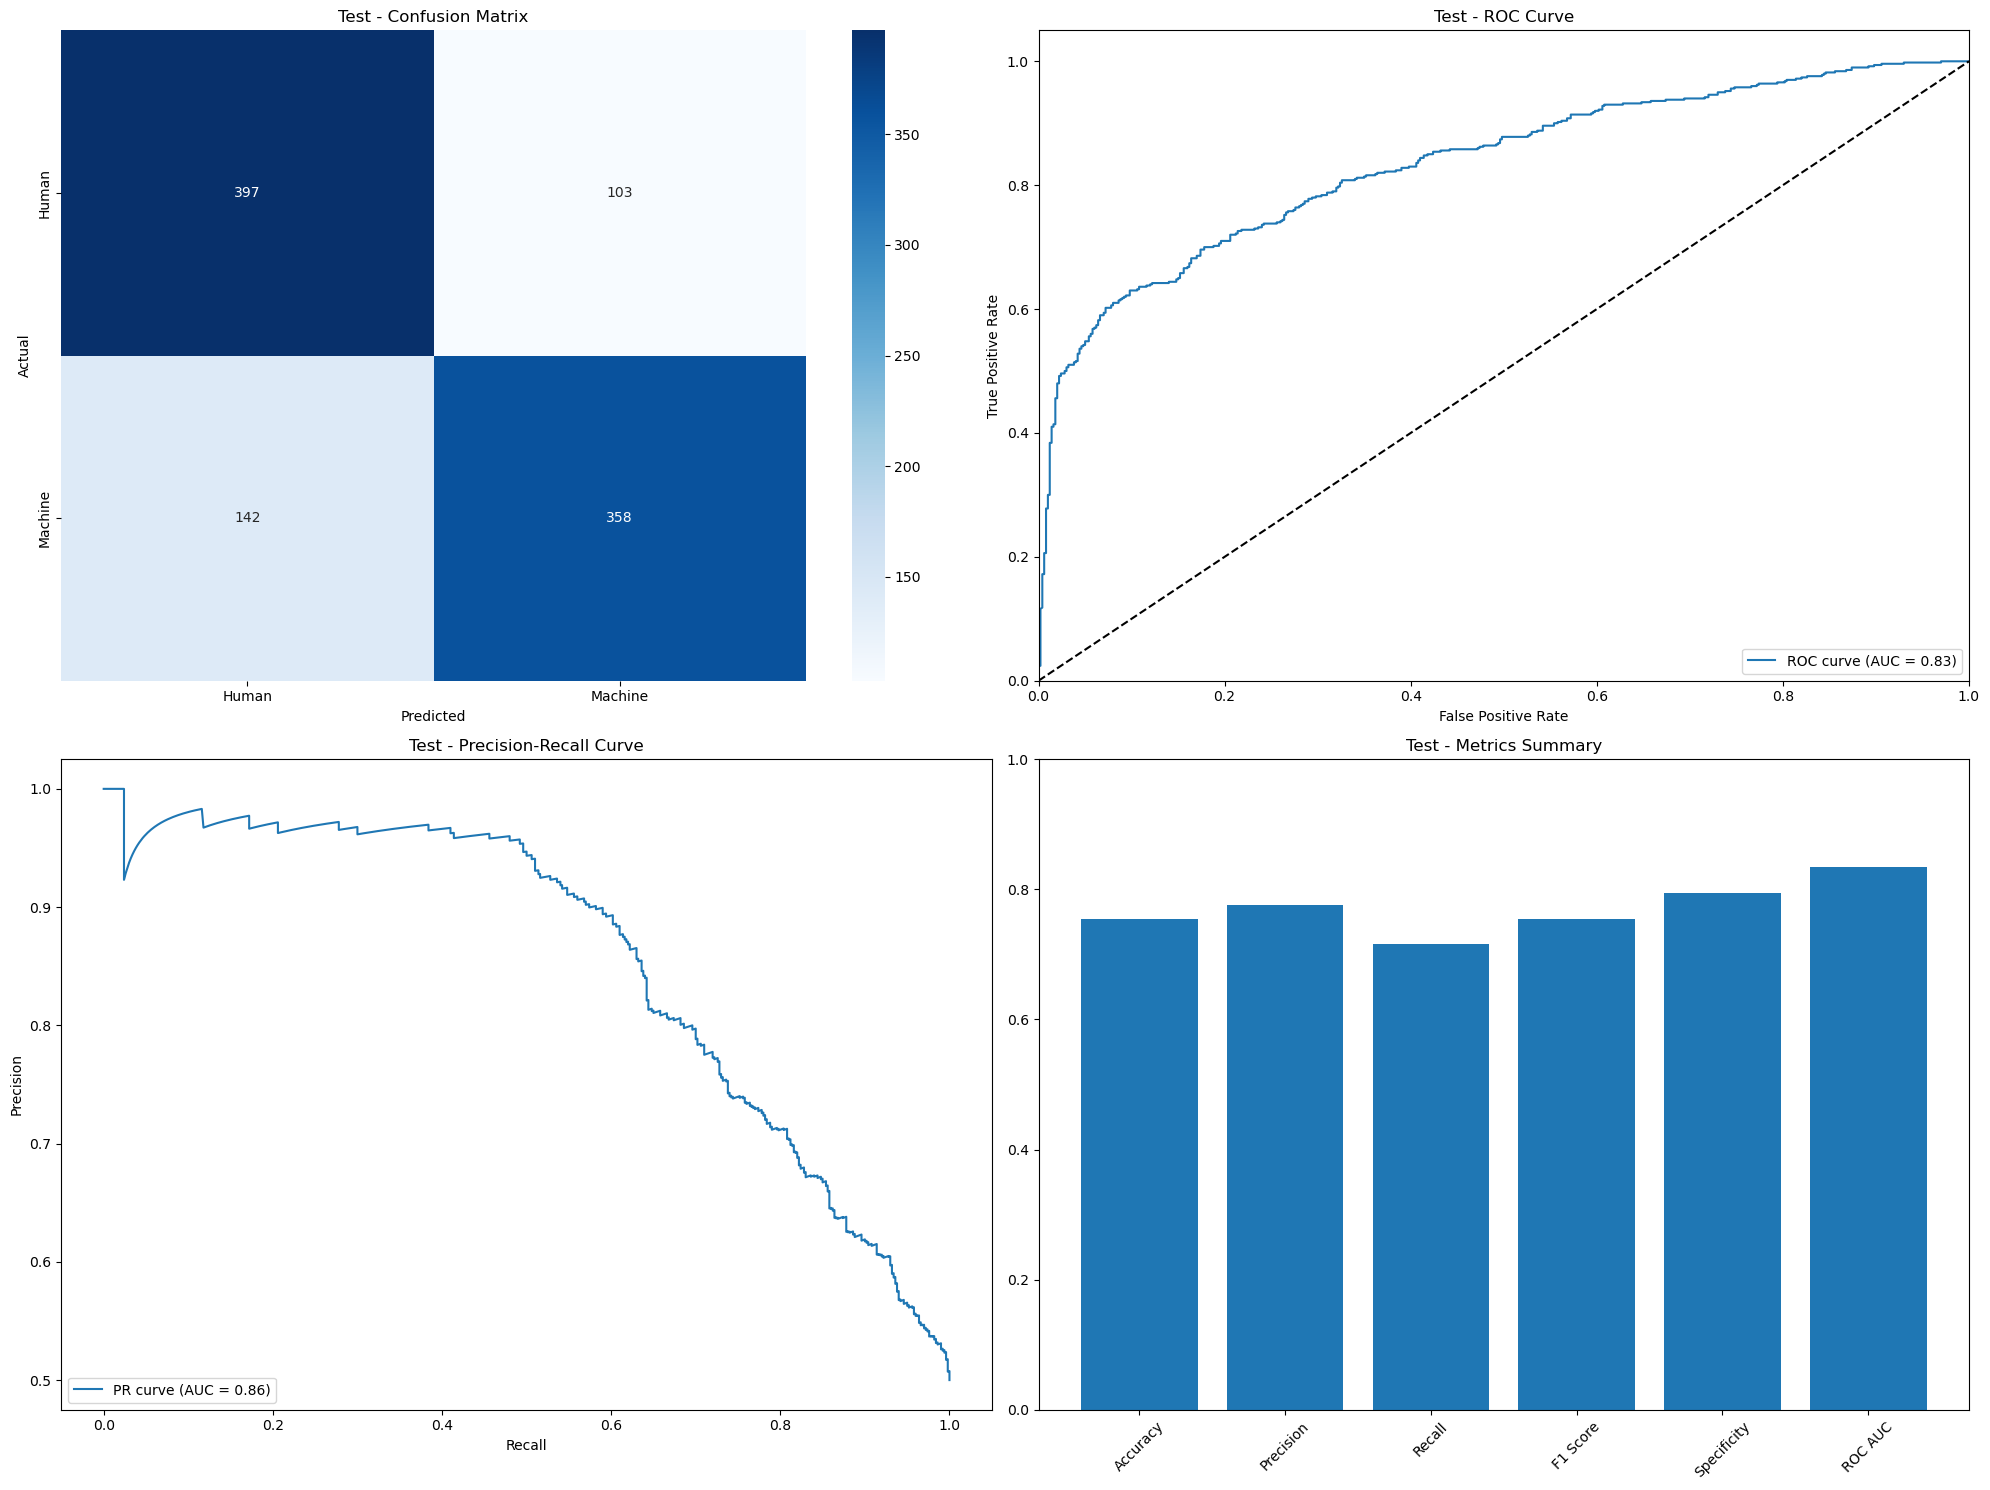


Detailed Performance Metrics:
--------------------------------------------------
Loss: 1.0656
Accuracy: 0.7550
Precision: 0.7766
Recall: 0.7160
F1 Score: 0.7546
Specificity: 0.7940
False Positive Rate: 0.2060
False Negative Rate: 0.2840
ROC AUC: 0.8341
PR AUC: 0.8560

Classification Report:
              precision  recall  f1-score   support
Human          0.736549   0.794  0.764196   500.000
Machine        0.776573   0.716  0.745057   500.000
accuracy       0.755000   0.755  0.755000     0.755
macro avg      0.756561   0.755  0.754627  1000.000
weighted avg   0.756561   0.755  0.754627  1000.000


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_metrics = evaluate_with_metrics(model, test_loader, device)

plot_metrics(test_metrics, title_prefix="Test - ")
print_detailed_metrics(test_metrics)

with open('test_metrics.json', 'w') as f:
    serializable_metrics = {k: v.tolist() if hasattr(v, 'tolist') else v 
                          for k, v in test_metrics.items() 
                          if k not in ['roc_curve', 'pr_curve']}
    json.dump(serializable_metrics, f, indent=4)

In [ ]:
import gc
gc.collect()